### Table of Contents

* [PCA](#pca)
* [PCA for compression](#compression)
* [Incremental PCA (IPCA)](#ipca)
* [Kernel PCA](#kernel_pca)
* [t-SNE](#t_sne)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
# inline plot 
%matplotlib inline  
# default figure size 
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible 
np.random.seed(42) 

In [2]:
# Generate data
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA <a class="anchor" id="pca"></a>

### Explicitely

In [35]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
# top singular values vectors (principal components)
W2 = Vt.T[:, :2]  # The rows of Vt are the principal components.
# transform 
X2D_using_svd = X_centered.dot(W2)
# inverse transform 
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])
# explained variance per component  
explained_var = np.square(s) / np.square(s).sum()  # square of singular value is eigenvalue
print(f'Explained variance: {explained_var}')

Explained variance: [0.40782396 0.3020019  0.29017414]


In [36]:
X.shape

(1000, 3)

### Using Scikit 

In [37]:
# using scikit 
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# you can indicate the total variance you want to preserve when feeding a float in [0, 1] to n_components
# pca = PCA(n_components=0.95)

X2D = pca.fit_transform(X)
print(f'''Principal components: 
{pca.components_}''')

Principal components: 
[[ 0.56791312  0.15670748  0.80803308]
 [-0.77712377 -0.2213858   0.5891239 ]]


In [38]:
X2D.shape

(1000, 2)

In [38]:
print(f'''using sklean 
{X2D[:5]}
using SVD 
{X2D_using_svd[:5]}
'''
)

using sklean 
[[ 1.26203346  0.42067648]
 [-0.08001485 -0.35272239]
 [ 1.17545763  0.36085729]
 [ 0.89305601 -0.30862856]
 [ 0.73016287 -0.25404049]]
using SVD 
[[-1.26203346 -0.42067648]
 [ 0.08001485  0.35272239]
 [-1.17545763 -0.36085729]
 [-0.89305601  0.30862856]
 [-0.73016287  0.25404049]]



In [39]:
# Recover the 3D points projected on the plane (PCA 2D subspace).
X3D_inv = pca.inverse_transform(X2D)
# reconstruction error 
print(f'Reconstruction Error: {np.mean(np.sum(np.square(X3D_inv - X), axis=1))}')


Reconstruction Error: 37.33439046246001


In [7]:
print(f'''explained variance by each component:
{pca.explained_variance_ratio_}
total unexplained variance:
{1 - pca.explained_variance_ratio_.sum()}
''')

explained variance by each component:
[0.84248607 0.14631839]
total unexplained variance:
0.011195535570688975



In [8]:
# The reconstructions from both methods are not identical because Scikit-Learn's PCA class automatically 
# takes care of reversing the mean centering, but if we subtract the mean
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)


True

## PCA for compression <a class="anchor" id="compression"></a>

In [9]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

C:\Users\Or\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [10]:
# utility functions

In [10]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [40]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [41]:
X.shape

(70000, 784)

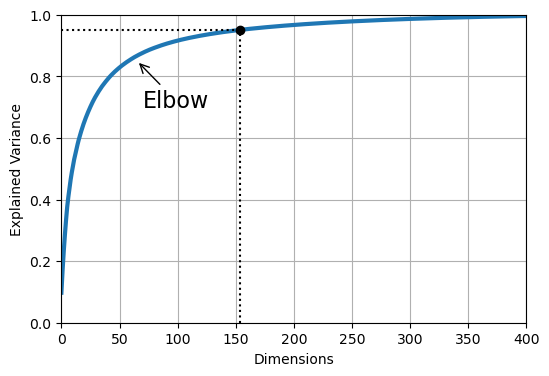

In [42]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

In [44]:
np.cumsum(pca.explained_variance_ratio_)

array([0.09744009, 0.16917988, 0.23084919, 0.28489267, 0.3337307 ,
       0.37658496, 0.4093545 , 0.43833213, 0.46585524, 0.48924912,
       0.51029979, 0.53064703, 0.54769476, 0.56465449, 0.58045374,
       0.59528384, 0.60853869, 0.62133858, 0.6332254 , 0.64478199,
       0.6555038 , 0.66561453, 0.67522969, 0.68431184, 0.69312954,
       0.70153756, 0.70961659, 0.71746944, 0.72485298, 0.73177067,
       0.73830656, 0.74476345, 0.75079106, 0.75665515, 0.76233659,
       0.76777779, 0.77281214, 0.7776885 , 0.78246685, 0.78713101,
       0.79164802, 0.7961104 , 0.80029297, 0.8042614 , 0.80809371,
       0.81184358, 0.8154482 , 0.81893118, 0.82231332, 0.82551015,
       0.82868747, 0.83180277, 0.83477265, 0.83763243, 0.84044853,
       0.84314582, 0.84581124, 0.84837248, 0.85089456, 0.85334272,
       0.85575155, 0.85813245, 0.86042978, 0.86264399, 0.86476973,
       0.86682969, 0.86885398, 0.87081143, 0.87272244, 0.87461125,
       0.87646313, 0.87826117, 0.88003399, 0.88177103, 0.88341

In [53]:
# plt.imshow(np.reshape(pca.components_[1], (28,28)))

Text(0.5, 1.0, 'Compressed')

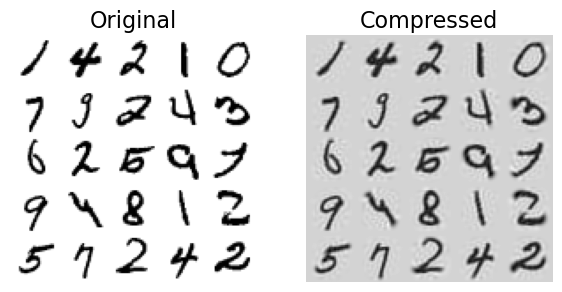

In [24]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))
plt.subplot(121)
# take samples by skipping 2100 samples 
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


## Incremental PCA (IPCA) <a class="anchor" id="ipca"></a>

In [15]:
## Exercise - check how better regular PCA is

....................................................................................................

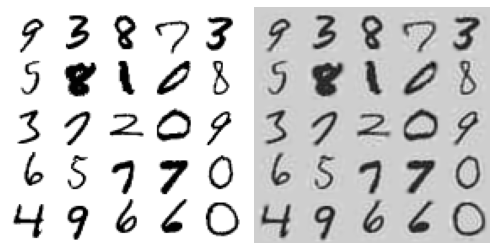

In [55]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

## Kernel PCA <a class="anchor" id="kernel_pca"></a>

In [30]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [32]:
X.shape

(1000, 3)

In [34]:
t.shape

(1000,)

In [57]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

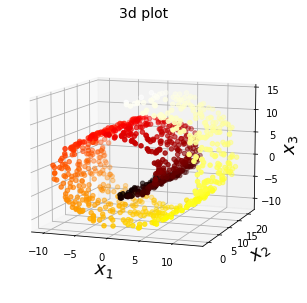

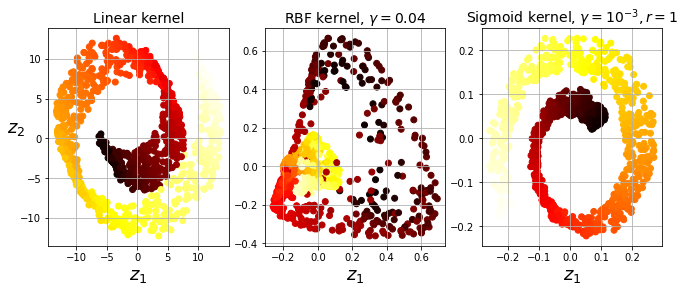

In [58]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
ax.set_title('3d plot', fontsize=14)

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

## T-SNE <a class="anchor" id="t_sne"></a>

In [59]:
## Helper functions
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title, ax):
    X = MinMaxScaler().fit_transform(X)

    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        ax.text(
            X[i, 0],
            X[i, 1],
            str(y[i]),
            color=plt.cm.Dark2(y[i]),
            fontdict={"weight": "bold", "size": 9},
        )

        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

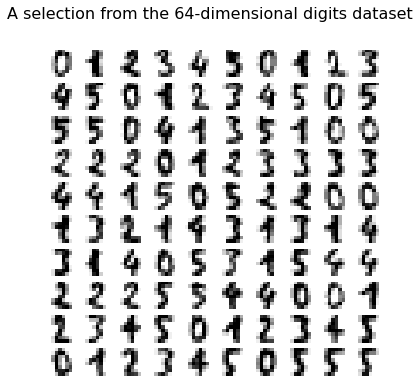

In [21]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape


import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)


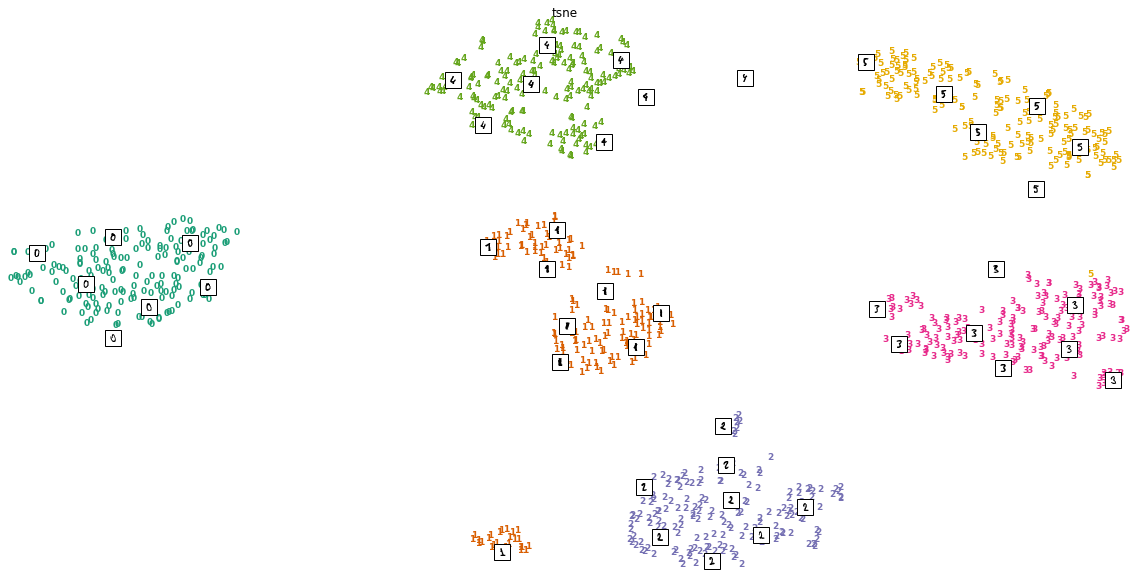

In [22]:
from sklearn.manifold import TSNE


t_sne = TSNE(n_components=2, init='random', random_state=0)
# t_sne = TSNE(n_components=2, init="pca", random_state=0)

projections = t_sne.fit_transform(X)
plot_embedding(projections, 'tsne', plt.gca())
